# Erkennung von handschriftlichen Zahlen

* https://opensourc.es/blog/tensorflow-mnist-nod
* https://github.com/opensourcesblog/tensorflow-mnist

In [28]:
%pylab inline
import pathlib
import cv2

Populating the interactive namespace from numpy and matplotlib


c:\python37\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['xticks']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Transfer image to black & white

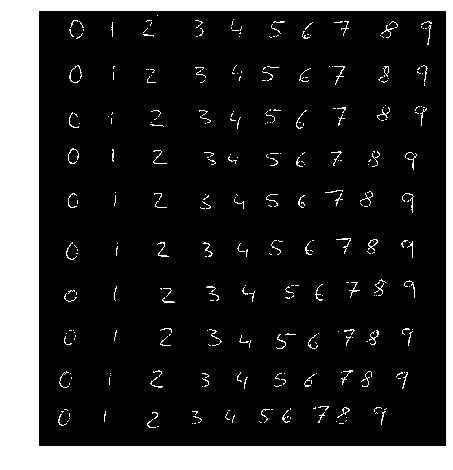

In [58]:
image_path = pathlib.Path("img")
input_img_path = image_path / "input.bmp"
bw_img_path = image_path / "bw.bmp"

color_complete = cv2.imread(str(input_img_path))
gray_complete = cv2.imread(str(input_img_path), cv2.IMREAD_GRAYSCALE)

(thresh, gray_complete) = cv2.threshold(255-gray_complete, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
cv2.imwrite(str(bw_img_path), gray_complete)

figsize(12, 8)
imshow(gray_complete, cmap="gray")
axis("off");

In [69]:
def getBestShift(img):
    cy,cx = ndimage.measurements.center_of_mass(img)
    print(cy,cx)

    rows,cols = img.shape
    shiftx = np.round(cols/2.0-cx).astype(int)
    shifty = np.round(rows/2.0-cy).astype(int)

    return shiftx,shifty

def shift(img,sx,sy):
    rows,cols = img.shape
    M = np.float32([[1,0,sx],[0,1,sy]])
    shifted = cv2.warpAffine(img,M,(cols,rows))
    return shifted


In [70]:
from scipy import ndimage
digit_image = -np.ones(gray_complete.shape)
height, width = gray_complete.shape

"""
crop into several images
"""
for cropped_width in range(100, 300, 20):
    for cropped_height in range(100, 300, 20):
        for shift_x in range(0, width - cropped_width, int(cropped_width / 4)):
            for shift_y in range(0, height - cropped_height, int(cropped_height / 4)):
                gray = gray_complete[
                    shift_y:shift_y + cropped_height,
                    shift_x:shift_x + cropped_width
                ]
                
                if np.count_nonzero(gray) <= 20:
                    continue
                    
                if ((np.sum(gray[0]) != 0) or
                    (np.sum(gray[:,0]) != 0) or
                    (np.sum(gray[-1]) != 0) or
                        (np.sum(gray[:,-1]) != 0)):
                    continue
                    
                top_left = np.array([shift_y, shift_x])
                bottom_right = np.array([shift_y+cropped_height, shift_x + cropped_width])
                
                while np.sum(gray[0]) == 0:
                    top_left[0] += 1
                    gray = gray[1:]

                while np.sum(gray[:,0]) == 0:
                    top_left[1] += 1
                    gray = np.delete(gray,0,1)

                while np.sum(gray[-1]) == 0:
                    bottom_right[0] -= 1
                    gray = gray[:-1]

                while np.sum(gray[:,-1]) == 0:
                    bottom_right[1] -= 1
                    gray = np.delete(gray,-1,1)
                    
                actual_w_h = bottom_right-top_left
                if (np.count_nonzero(digit_image[top_left[0]:bottom_right[0],top_left[1]:bottom_right[1]]+1) >
                        0.2*actual_w_h[0]*actual_w_h[1]):
                    continue
                    
                digit_image[top_left[0]:bottom_right[0],top_left[1]:bottom_right[1]]
                
                rows,cols = gray.shape
                compl_dif = abs(rows - cols)
                half_Sm = int(compl_dif / 2)
                half_Big = int(half_Sm if half_Sm * 2 == compl_dif else half_Sm + 1)
               
                if rows > cols:
                    gray = np.lib.pad(gray,((0,0), (half_Sm,half_Big)),'constant')
                else:
                    gray = np.lib.pad(gray,((half_Sm,half_Big), (0,0)),'constant')
                    
                gray = cv2.resize(gray, (20, 20))
                gray = np.lib.pad(gray,((4,4),(4,4)),'constant')

                shiftx,shifty = getBestShift(gray)
                shifted = shift(gray,shiftx,shifty)
                gray = shifted
                
                flatten = gray.flatten() / 255.0
                
                cv2.rectangle(color_complete, tuple(top_left[::-1]),tuple(bottom_right[::-1]),color=(0,255,0),thickness=5)

cv2.imwrite("img/digitized_image.png", color_complete)

14.098927706675891 12.808785887236251
14.098927706675891 12.808785887236251
14.464797507788163 12.949394254067151
14.464797507788163 12.949394254067151
15.41304347826087 12.478260869565217
15.41304347826087 12.478260869565217
13.700368220682769 12.973350808213194
13.700368220682769 12.973350808213194
13.983375433237384 12.688656523526992
13.983375433237384 12.688656523526992
14.930993456276026 12.53048780487805
13.47385095041738 12.054510711053002
13.47385095041738 12.054510711053002
13.985395051875498 12.041899441340782
13.985395051875498 12.041899441340782
14.098927706675891 12.808785887236251
14.098927706675891 12.808785887236251
14.464797507788163 12.949394254067151
14.464797507788163 12.949394254067151
13.967512087539232 13.059462210535244
13.967512087539232 13.059462210535244
14.625667697497892 13.308195108237278
15.41304347826087 12.478260869565217
15.41304347826087 12.478260869565217
13.700368220682769 12.973350808213194
13.700368220682769 12.973350808213194
13.983375433237384 

11.588663255516469 11.737607930924208
11.588663255516469 11.737607930924208
13.16030658838878 12.512883235485976
13.16030658838878 12.512883235485976
13.089195465100396 11.157765332604836
13.089195465100396 11.157765332604836
12.243752331219694 11.758672137262215
12.225289732043995 12.246622868531778
12.225289732043995 12.246622868531778
12.89087496648494 11.036017517204398
12.89087496648494 11.036017517204398
13.430263800683928 12.703163165608208
13.430263800683928 12.703163165608208
13.16030658838878 12.512883235485976
13.16030658838878 12.512883235485976
12.225289732043995 12.246622868531778
12.225289732043995 12.246622868531778
12.89087496648494 11.036017517204398
12.89087496648494 11.036017517204398
13.430263800683928 12.703163165608208
13.430263800683928 12.703163165608208
12.489910999388545 12.186221890074053
12.489910999388545 12.186221890074053
12.884510374954496 11.007280669821624
12.884510374954496 11.007280669821624
12.489910999388545 12.186221890074053
12.489910999388545 1

13.720788756031046 13.50681770505559
13.720788756031046 13.50681770505559
14.468043150446585 14.639948961837375
14.468043150446585 14.639948961837375
17.586821015138025 8.041406945681212
17.586821015138025 8.041406945681212
13.726818006925741 13.404129793510325
13.364136904761905 13.276339285714286
13.364136904761905 13.276339285714286
14.462940212940213 13.377559377559377
14.462940212940213 13.377559377559377
13.770021042208194 13.03267731154846
13.770021042208194 13.03267731154846
13.807042879360143 13.275494334592313
13.807042879360143 13.275494334592313
14.00161410479265 13.061335982120685
14.00161410479265 13.061335982120685
14.56115200826553 12.546429032674673
14.56115200826553 12.546429032674673
14.56115200826553 12.546429032674673
13.42676797194623 13.575920514319112
13.42676797194623 13.575920514319112
13.720788756031046 13.50681770505559
13.720788756031046 13.50681770505559
14.367483594482389 13.481585643498057
14.367483594482389 13.481585643498057
17.586821015138025 8.041406

16.49057256530012 11.369226777374157
16.49057256530012 11.369226777374157
15.787183196025408 10.56593924910383
15.787183196025408 10.56593924910383
15.171042760690172 11.881791876540564
15.171042760690172 11.881791876540564
15.695695411280012 11.397712743287398
15.695695411280012 11.397712743287398
14.980458410767584 10.134876386777046
14.980458410767584 10.134876386777046
16.148301706266942 12.350023919630043
16.148301706266942 12.350023919630043
16.148301706266942 12.350023919630043
15.179326728083899 11.04530969349325
15.179326728083899 11.04530969349325
16.49057256530012 11.369226777374157
16.49057256530012 11.369226777374157
16.148301706266942 12.350023919630043
16.148301706266942 12.350023919630043
16.148301706266942 12.350023919630043
14.96732268845154 17.464909023393986
14.96732268845154 17.464909023393986
16.18119394618834 11.996216367713005
16.18119394618834 11.996216367713005
16.18119394618834 11.996216367713005
15.179326728083899 11.04530969349325
15.179326728083899 11.0453

14.468043150446585 14.639948961837375
17.586821015138025 8.041406945681212
13.364136904761905 13.276339285714286
13.364136904761905 13.276339285714286
13.364136904761905 13.276339285714286
14.462940212940213 13.377559377559377
14.462940212940213 13.377559377559377
14.462940212940213 13.377559377559377
13.770021042208194 13.03267731154846
13.770021042208194 13.03267731154846
13.807042879360143 13.275494334592313
13.807042879360143 13.275494334592313
13.807042879360143 13.275494334592313
14.00161410479265 13.061335982120685
14.00161410479265 13.061335982120685
14.00161410479265 13.061335982120685
14.56115200826553 12.546429032674673
14.56115200826553 12.546429032674673
14.56115200826553 12.546429032674673
13.42676797194623 13.575920514319112
13.42676797194623 13.575920514319112
13.720788756031046 13.50681770505559
13.720788756031046 13.50681770505559
14.367483594482389 13.481585643498057
17.586821015138025 8.041406945681212
13.364136904761905 13.276339285714286
13.364136904761905 13.2763

16.148301706266942 12.350023919630043
16.148301706266942 12.350023919630043
16.148301706266942 12.350023919630043
15.179326728083899 11.04530969349325
15.179326728083899 11.04530969349325
16.49057256530012 11.369226777374157
16.49057256530012 11.369226777374157
16.148301706266942 12.350023919630043
16.148301706266942 12.350023919630043
16.148301706266942 12.350023919630043
14.96732268845154 17.464909023393986
14.96732268845154 17.464909023393986
16.18119394618834 11.996216367713005
16.18119394618834 11.996216367713005
15.179326728083899 11.04530969349325
15.179326728083899 11.04530969349325
16.0083100069979 11.482680195941217
16.0083100069979 11.482680195941217
16.18119394618834 11.996216367713005
16.18119394618834 11.996216367713005
10.620810367942797 15.409950841650529
10.79037092544024 14.499750218558761
10.79037092544024 14.499750218558761
10.79037092544024 14.499750218558761
16.0083100069979 11.482680195941217
16.0083100069979 11.482680195941217
10.377508800098807 16.5008336935712

14.468043150446585 14.639948961837375
8.69504256384577 9.517776664997497
17.586821015138025 8.041406945681212
17.586821015138025 8.041406945681212
13.726818006925741 13.404129793510325
13.364136904761905 13.276339285714286
13.364136904761905 13.276339285714286
13.364136904761905 13.276339285714286
14.462940212940213 13.377559377559377
14.462940212940213 13.377559377559377
14.462940212940213 13.377559377559377
13.770021042208194 13.03267731154846
13.770021042208194 13.03267731154846
13.770021042208194 13.03267731154846
13.807042879360143 13.275494334592313
13.807042879360143 13.275494334592313
13.807042879360143 13.275494334592313
14.00161410479265 13.061335982120685
14.00161410479265 13.061335982120685
14.56115200826553 12.546429032674673
13.42676797194623 13.575920514319112
13.720788756031046 13.50681770505559
13.720788756031046 13.50681770505559
14.367483594482389 13.481585643498057
9.568939393939393 8.034090909090908
17.586821015138025 8.041406945681212
17.586821015138025 8.04140694

16.49057256530012 11.369226777374157
15.787183196025408 10.56593924910383
15.787183196025408 10.56593924910383
15.171042760690172 11.881791876540564
15.171042760690172 11.881791876540564
15.695695411280012 11.397712743287398
15.695695411280012 11.397712743287398
14.980458410767584 10.134876386777046
14.980458410767584 10.134876386777046
14.980458410767584 10.134876386777046
16.148301706266942 12.350023919630043
16.148301706266942 12.350023919630043
16.148301706266942 12.350023919630043
15.179326728083899 11.04530969349325
15.179326728083899 11.04530969349325
16.49057256530012 11.369226777374157
16.148301706266942 12.350023919630043
16.148301706266942 12.350023919630043
16.148301706266942 12.350023919630043
14.96732268845154 17.464909023393986
14.96732268845154 17.464909023393986
14.96732268845154 17.464909023393986
16.18119394618834 11.996216367713005
16.18119394618834 11.996216367713005
16.18119394618834 11.996216367713005
15.179326728083899 11.04530969349325
15.179326728083899 11.045

14.462940212940213 13.377559377559377
14.462940212940213 13.377559377559377
13.770021042208194 13.03267731154846
13.770021042208194 13.03267731154846
13.807042879360143 13.275494334592313
13.807042879360143 13.275494334592313
16.672240802675585 12.218896321070234
14.373327056291613 12.44575963413814
14.58409290392276 13.705421646073864
16.672240802675585 12.218896321070234
14.373327056291613 12.44575963413814
13.634615384615385 12.961538461538462
14.66468984321745 13.848466257668711
14.678693083072645 12.962808481056657
14.373327056291613 12.44575963413814
13.634615384615385 12.961538461538462
14.919582167133147 11.210415833666534
14.168100408969115 11.756310816527993
14.168100408969115 11.756310816527993
14.112074483561246 12.569275530986324
14.112074483561246 12.569275530986324
14.055110726393998 13.503282117867705
14.055110726393998 13.503282117867705
14.66468984321745 13.848466257668711
14.678693083072645 12.962808481056657
14.919582167133147 11.210415833666534
14.168100408969115 1

11.208274604095847 13.894619019981759
11.208274604095847 13.894619019981759
10.346257668711656 14.571288343558281
11.027217450053083 14.392819225943441
11.208274604095847 13.894619019981759
11.208274604095847 13.894619019981759
14.098927706675891 12.808785887236251
16.505890753302392 13.183862906104963
13.983375433237384 12.688656523526992
13.983375433237384 12.688656523526992
14.930993456276026 12.53048780487805
14.930993456276026 12.53048780487805
13.47385095041738 12.054510711053002
13.985395051875498 12.041899441340782
14.098927706675891 12.808785887236251
14.625667697497892 13.308195108237278
14.625667697497892 13.308195108237278
16.505890753302392 13.183862906104963
13.983375433237384 12.688656523526992
13.983375433237384 12.688656523526992
14.930993456276026 12.53048780487805
14.930993456276026 12.53048780487805
13.47385095041738 12.054510711053002
13.985395051875498 12.041899441340782
14.625667697497892 13.308195108237278
14.625667697497892 13.308195108237278
16.505890753302392

14.930993456276026 12.53048780487805
14.930993456276026 12.53048780487805
13.985395051875498 12.041899441340782
14.625667697497892 13.308195108237278
16.505890753302392 13.183862906104963
13.983375433237384 12.688656523526992
13.720788756031046 13.50681770505559
21.033824804856895 14.0
15.800942285041225 13.045936395759718
13.720788756031046 13.50681770505559
21.033824804856895 14.0
13.364136904761905 13.276339285714286
14.462940212940213 13.377559377559377
13.770021042208194 13.03267731154846
13.807042879360143 13.275494334592313
15.800942285041225 13.045936395759718
13.720788756031046 13.50681770505559
5.801255230125523 11.0
13.364136904761905 13.276339285714286
14.462940212940213 13.377559377559377
13.770021042208194 13.03267731154846
13.807042879360143 13.275494334592313
15.800942285041225 13.045936395759718
13.720788756031046 13.50681770505559
20.85987261146497 11.0
13.364136904761905 13.276339285714286
14.462940212940213 13.377559377559377
13.770021042208194 13.03267731154846
13.

14.264794383149448 14.363757940488131
10.172606993384637 15.318685027676523
12.308542286442838 13.685082872928177
10.172606993384637 15.318685027676523
11.673082893511332 14.228190003104626
14.049031416240089 14.407056107598113
10.90271926464956 13.816545384909997
14.801804812834225 13.311497326203208
14.049031416240089 14.407056107598113
10.90271926464956 13.816545384909997
9.704169046259281 14.087949743003998
9.410690423162583 14.145657015590201
11.169494303745594 14.183673469387756
10.808385967582376 14.345559698653071
10.808385967582376 14.345559698653071
9.704169046259281 14.087949743003998
9.410690423162583 14.145657015590201
11.169494303745594 14.183673469387756
11.726303317535544 14.351895734597157
11.726303317535544 14.351895734597157
14.541303232426886 13.2252437147255
16.505890753302392 13.183862906104963
14.007768800497203 13.344002486016159
14.930993456276026 12.53048780487805
12.762045646661031 13.098901098901099
13.81273816004355 13.744692433315187
14.678486055776892 13.

16.190258751902586 13.58904109589041
15.401626646010845 13.015104570100696
12.368996671421778 12.50071326676177
13.639898562975485 12.805579036348266
15.849292929292929 13.013333333333334
15.849292929292929 13.013333333333334
16.190258751902586 13.58904109589041
11.335714285714285 12.979761904761904
15.004884004884005 12.931929181929181
16.0083100069979 11.482680195941217
8.307463795024137 14.469736353509097
14.264794383149448 14.363757940488131
10.749118165784832 13.538359788359788
14.353149327671622 14.505307855626327
14.353149327671622 14.505307855626327
8.307463795024137 14.469736353509097
14.264794383149448 14.363757940488131
11.848343685300208 13.8027950310559
11.848343685300208 13.8027950310559
12.308542286442838 13.685082872928177
11.673082893511332 14.228190003104626
11.673082893511332 14.228190003104626
14.67458777885548 14.36905916585839
13.418193506910962 13.553841208614593
10.90271926464956 13.816545384909997
10.900091659028414 14.445462878093492
14.801804812834225 13.3114

13.835765137097342 14.820962853316416
12.585285966238347 14.38044847568657
12.585285966238347 14.38044847568657
13.695652173913043 14.195652173913043
13.695652173913043 14.195652173913043
11.638297872340425 13.97872340425532
12.373371015858062 13.613754121526142
12.373371015858062 13.613754121526142
16.189082723691616 11.269217782779966
14.647571773544406 14.057016367051247
13.1035127296165 13.752626490493071
13.1035127296165 13.752626490493071
11.163487738419619 15.33242506811989
12.360054424854017 14.584216792335166
12.360054424854017 14.584216792335166
12.947247706422019 14.82200879204893
12.535714285714286 13.964285714285714
12.535714285714286 13.964285714285714
13.835765137097342 14.820962853316416
13.835765137097342 14.820962853316416
14.647571773544406 14.057016367051247
13.1035127296165 13.752626490493071
13.1035127296165 13.752626490493071
11.163487738419619 15.33242506811989
12.360054424854017 14.584216792335166
12.360054424854017 14.584216792335166
12.947247706422019 14.8220

13.983375433237384 12.688656523526992
14.930993456276026 12.53048780487805
14.930993456276026 12.53048780487805
13.47385095041738 12.054510711053002
13.47385095041738 12.054510711053002
13.985395051875498 12.041899441340782
13.985395051875498 12.041899441340782
14.098927706675891 12.808785887236251
14.098927706675891 12.808785887236251
14.464797507788163 12.949394254067151
14.464797507788163 12.949394254067151
13.967512087539232 13.059462210535244
13.967512087539232 13.059462210535244
14.625667697497892 13.308195108237278
14.625667697497892 13.308195108237278
15.41304347826087 12.478260869565217
15.41304347826087 12.478260869565217
13.700368220682769 12.973350808213194
13.700368220682769 12.973350808213194
13.983375433237384 12.688656523526992
13.983375433237384 12.688656523526992
14.930993456276026 12.53048780487805
14.930993456276026 12.53048780487805
13.47385095041738 12.054510711053002
13.47385095041738 12.054510711053002
13.985395051875498 12.041899441340782
13.985395051875498 12.

13.57675016056519 13.025904517233997
13.57675016056519 13.025904517233997
13.576665009940358 13.179174950298211
13.068452746712548 13.018925894064152
13.068452746712548 13.018925894064152
13.53005272407733 13.16473345049795
13.53005272407733 13.16473345049795
12.335144927536232 13.21046462063086
12.711786372007367 12.865490862728432
12.711786372007367 12.865490862728432
14.205642299503193 13.211408800567778
14.205642299503193 13.211408800567778
14.90657929690959 12.706455326308333
14.90657929690959 12.706455326308333
13.268292682926829 13.341463414634147
13.268292682926829 13.341463414634147
15.256222053488568 13.438707500210917
15.256222053488568 13.438707500210917
13.231455346053968 13.495201535508638
13.231455346053968 13.495201535508638
14.90657929690959 12.706455326308333
14.90657929690959 12.706455326308333
13.268292682926829 13.341463414634147
13.268292682926829 13.341463414634147
15.256222053488568 13.438707500210917
15.256222053488568 13.438707500210917
13.231455346053968 13.4

10.616890870015125 15.166600334315053
10.616890870015125 15.166600334315053
10.346257668711656 14.571288343558281
11.027217450053083 14.392819225943441
11.027217450053083 14.392819225943441
11.208274604095847 13.894619019981759
11.208274604095847 13.894619019981759
14.721582879063194 12.535836866545528
14.721582879063194 12.535836866545528
14.721582879063194 12.535836866545528
14.098927706675891 12.808785887236251
14.098927706675891 12.808785887236251
14.464797507788163 12.949394254067151
14.464797507788163 12.949394254067151
15.41304347826087 12.478260869565217
15.41304347826087 12.478260869565217
13.700368220682769 12.973350808213194
13.700368220682769 12.973350808213194
13.983375433237384 12.688656523526992
13.983375433237384 12.688656523526992
13.983375433237384 12.688656523526992
14.930993456276026 12.53048780487805
14.930993456276026 12.53048780487805
13.47385095041738 12.054510711053002
13.47385095041738 12.054510711053002
13.47385095041738 12.054510711053002
13.985395051875498 

14.647571773544406 14.057016367051247
14.647571773544406 14.057016367051247
13.1035127296165 13.752626490493071
13.1035127296165 13.752626490493071
13.1035127296165 13.752626490493071
12.360054424854017 14.584216792335166
12.360054424854017 14.584216792335166
12.535714285714286 13.964285714285714
12.535714285714286 13.964285714285714
12.535714285714286 13.964285714285714
13.835765137097342 14.820962853316416
13.835765137097342 14.820962853316416
14.647571773544406 14.057016367051247
14.647571773544406 14.057016367051247
13.1035127296165 13.752626490493071
13.1035127296165 13.752626490493071
13.1035127296165 13.752626490493071
12.360054424854017 14.584216792335166
12.360054424854017 14.584216792335166
12.535714285714286 13.964285714285714
12.535714285714286 13.964285714285714
12.535714285714286 13.964285714285714
13.835765137097342 14.820962853316416
13.835765137097342 14.820962853316416
13.576665009940358 13.179174950298211
13.57675016056519 13.025904517233997
13.57675016056519 13.0259

11.416439320601954 15.078500396022177
11.416439320601954 15.078500396022177
11.023242905710124 15.350933185318809
11.023242905710124 15.350933185318809
10.616890870015125 15.166600334315053
10.616890870015125 15.166600334315053
11.169494303745594 14.183673469387756
11.169494303745594 14.183673469387756
10.808385967582376 14.345559698653071
10.808385967582376 14.345559698653071
10.346257668711656 14.571288343558281
10.346257668711656 14.571288343558281
11.027217450053083 14.392819225943441
11.027217450053083 14.392819225943441
11.208274604095847 13.894619019981759
11.208274604095847 13.894619019981759
10.839064191158105 14.248688702023145
10.839064191158105 14.248688702023145
10.616890870015125 15.166600334315053
10.616890870015125 15.166600334315053
10.346257668711656 14.571288343558281
10.346257668711656 14.571288343558281
11.027217450053083 14.392819225943441
11.027217450053083 14.392819225943441
11.208274604095847 13.894619019981759
11.208274604095847 13.894619019981759
14.721582879

13.1035127296165 13.752626490493071
13.1035127296165 13.752626490493071
13.835765137097342 14.820962853316416
13.835765137097342 14.820962853316416
12.585285966238347 14.38044847568657
13.695652173913043 14.195652173913043
11.638297872340425 13.97872340425532
11.638297872340425 13.97872340425532
12.373371015858062 13.613754121526142
6.755052790346908 10.245852187028657
16.189082723691616 11.269217782779966
12.762284442796217 14.378407194511404
14.647571773544406 14.057016367051247
14.647571773544406 14.057016367051247
14.647571773544406 14.057016367051247
13.1035127296165 13.752626490493071
13.1035127296165 13.752626490493071
13.1035127296165 13.752626490493071
12.360054424854017 14.584216792335166
12.360054424854017 14.584216792335166
12.360054424854017 14.584216792335166
12.535714285714286 13.964285714285714
12.535714285714286 13.964285714285714
12.535714285714286 13.964285714285714
13.835765137097342 14.820962853316416
13.835765137097342 14.820962853316416
14.647571773544406 14.0570

11.208274604095847 13.894619019981759
10.839064191158105 14.248688702023145
10.839064191158105 14.248688702023145
11.416439320601954 15.078500396022177
11.416439320601954 15.078500396022177
11.023242905710124 15.350933185318809
11.023242905710124 15.350933185318809
10.616890870015125 15.166600334315053
10.616890870015125 15.166600334315053
11.169494303745594 14.183673469387756
11.169494303745594 14.183673469387756
11.169494303745594 14.183673469387756
10.808385967582376 14.345559698653071
10.808385967582376 14.345559698653071
10.346257668711656 14.571288343558281
11.027217450053083 14.392819225943441
11.208274604095847 13.894619019981759
11.208274604095847 13.894619019981759
10.839064191158105 14.248688702023145
10.839064191158105 14.248688702023145
10.616890870015125 15.166600334315053
10.616890870015125 15.166600334315053
10.346257668711656 14.571288343558281
11.027217450053083 14.392819225943441
11.208274604095847 13.894619019981759
11.208274604095847 13.894619019981759
14.721582879

13.231455346053968 13.495201535508638
14.90657929690959 12.706455326308333
14.90657929690959 12.706455326308333
13.268292682926829 13.341463414634147
13.268292682926829 13.341463414634147
15.256222053488568 13.438707500210917
15.256222053488568 13.438707500210917
13.231455346053968 13.495201535508638
13.268292682926829 13.341463414634147
13.268292682926829 13.341463414634147
11.588663255516469 11.737607930924208
13.089195465100396 11.157765332604836
12.243752331219694 11.758672137262215
12.243752331219694 11.758672137262215
12.225289732043995 12.246622868531778
12.225289732043995 12.246622868531778
8.282904689863843 12.064599092284418
8.282904689863843 12.064599092284418
13.16030658838878 12.512883235485976
13.089195465100396 11.157765332604836
12.243752331219694 11.758672137262215
12.243752331219694 11.758672137262215
12.225289732043995 12.246622868531778
12.225289732043995 12.246622868531778
8.63383479988646 11.359920522282145
8.63383479988646 11.359920522282145
19.256302521008404 12

11.638297872340425 13.97872340425532
12.373371015858062 13.613754121526142
14.43968432919955 13.961292747087562
12.762284442796217 14.378407194511404
14.647571773544406 14.057016367051247
14.647571773544406 14.057016367051247
13.1035127296165 13.752626490493071
11.578249336870027 13.36551724137931
13.835765137097342 14.820962853316416
11.638297872340425 13.97872340425532
11.638297872340425 13.97872340425532
6.755052790346908 10.245852187028657
15.083786724700762 13.075081610446137
16.189082723691616 11.269217782779966
14.647571773544406 14.057016367051247
14.647571773544406 14.057016367051247
13.1035127296165 13.752626490493071
11.578249336870027 13.36551724137931
12.360054424854017 14.584216792335166
14.16542750929368 14.246282527881041
12.535714285714286 13.964285714285714
13.835765137097342 14.820962853316416
14.647571773544406 14.057016367051247
14.647571773544406 14.057016367051247
13.1035127296165 13.752626490493071
11.578249336870027 13.36551724137931
12.360054424854017 14.58421

14.353149327671622 14.505307855626327
10.96241518639933 15.75924372951132
9.883732566139221 15.664957158046157
11.114948281614948 15.973306639973307
10.839918699186992 14.499268292682927
9.883732566139221 15.664957158046157
11.592867277183027 13.573326454275763
10.172606993384637 15.318685027676523
11.592867277183027 13.573326454275763
11.673082893511332 14.228190003104626
13.144077669902913 13.275339805825242
13.908899420747762 15.219655081621907
14.627376425855513 14.40650360365473
13.144077669902913 13.275339805825242
13.058086285852012 13.865087973005544
14.049031416240089 14.407056107598113
14.105828854898718 14.222405952873087
13.908899420747762 15.219655081621907
14.627376425855513 14.40650360365473
13.058086285852012 13.865087973005544
13.908899420747762 15.219655081621907
10.839064191158105 14.248688702023145
10.616890870015125 15.166600334315053
11.169494303745594 14.183673469387756
11.208274604095847 13.894619019981759
10.616890870015125 15.166600334315053
11.169494303745594

9.410690423162583 14.145657015590201
13.056655025223128 13.589833139309274
10.808385967582376 14.345559698653071
12.752320185614849 13.183294663573086
14.116424116424117 13.375606375606376
14.541303232426886 13.2252437147255
16.505890753302392 13.183862906104963
16.505890753302392 13.183862906104963
14.007768800497203 13.344002486016159
17.951172809956915 13.822403063666826
14.930993456276026 12.53048780487805
12.762045646661031 13.098901098901099
13.81273816004355 13.744692433315187
13.81273816004355 13.744692433315187
14.678486055776892 13.121513944223107
14.541303232426886 13.2252437147255
14.644792293798917 13.700180614087898
9.855276907001045 13.320271682340648
16.505890753302392 13.183862906104963
16.505890753302392 13.183862906104963
14.007768800497203 13.344002486016159
17.951172809956915 13.822403063666826
14.930993456276026 12.53048780487805
12.762045646661031 13.098901098901099
13.81273816004355 13.744692433315187
13.81273816004355 13.744692433315187
14.678486055776892 13.12

13.807042879360143 13.275494334592313
14.00161410479265 13.061335982120685
14.00161410479265 13.061335982120685
14.56115200826553 12.546429032674673
14.56115200826553 12.546429032674673
13.42676797194623 13.575920514319112
13.42676797194623 13.575920514319112
13.720788756031046 13.50681770505559
13.720788756031046 13.50681770505559
14.468043150446585 14.639948961837375
14.468043150446585 14.639948961837375
17.586821015138025 8.041406945681212
13.726818006925741 13.404129793510325
13.364136904761905 13.276339285714286
13.364136904761905 13.276339285714286
14.462940212940213 13.377559377559377
14.462940212940213 13.377559377559377
13.770021042208194 13.03267731154846
13.770021042208194 13.03267731154846
13.807042879360143 13.275494334592313
13.807042879360143 13.275494334592313
13.807042879360143 13.275494334592313
14.00161410479265 13.061335982120685
14.00161410479265 13.061335982120685
14.56115200826553 12.546429032674673
14.56115200826553 12.546429032674673
14.468043150446585 14.63994

11.592867277183027 13.573326454275763
11.592867277183027 13.573326454275763
10.172606993384637 15.318685027676523
10.172606993384637 15.318685027676523
12.865394274234053 15.206303365143144
13.442245119305857 14.107483731019522
13.95343252108716 14.523137300843487
13.95343252108716 14.523137300843487
13.908899420747762 15.219655081621907
14.627376425855513 14.40650360365473
14.627376425855513 14.40650360365473
13.442245119305857 14.107483731019522
13.95343252108716 14.523137300843487
13.95343252108716 14.523137300843487
13.144077669902913 13.275339805825242
13.144077669902913 13.275339805825242
14.049031416240089 14.407056107598113
14.049031416240089 14.407056107598113
13.493156153758413 14.337173491502224
13.493156153758413 14.337173491502224
11.222942683317322 13.918027537624079
11.222942683317322 13.918027537624079
12.878760031856888 14.15021748453103
12.878760031856888 14.15021748453103
13.908899420747762 15.219655081621907
14.627376425855513 14.40650360365473
14.627376425855513 14

14.055110726393998 13.503282117867705
13.695652173913043 14.195652173913043
13.695652173913043 14.195652173913043
11.638297872340425 13.97872340425532
11.638297872340425 13.97872340425532
12.585285966238347 14.38044847568657
12.585285966238347 14.38044847568657
12.585285966238347 14.38044847568657
13.695652173913043 14.195652173913043
13.695652173913043 14.195652173913043
11.638297872340425 13.97872340425532
11.638297872340425 13.97872340425532
12.373371015858062 13.613754121526142
12.373371015858062 13.613754121526142
12.762284442796217 14.378407194511404
12.762284442796217 14.378407194511404
14.647571773544406 14.057016367051247
14.647571773544406 14.057016367051247
13.1035127296165 13.752626490493071
13.1035127296165 13.752626490493071
13.835765137097342 14.820962853316416
13.835765137097342 14.820962853316416
12.585285966238347 14.38044847568657
12.585285966238347 14.38044847568657
12.585285966238347 14.38044847568657
13.695652173913043 14.195652173913043
13.695652173913043 14.1956

10.808385967582376 14.345559698653071
10.808385967582376 14.345559698653071
10.839064191158105 14.248688702023145
10.839064191158105 14.248688702023145
11.416439320601954 15.078500396022177
11.416439320601954 15.078500396022177
11.023242905710124 15.350933185318809
11.023242905710124 15.350933185318809
11.169494303745594 14.183673469387756
11.169494303745594 14.183673469387756
10.808385967582376 14.345559698653071
10.808385967582376 14.345559698653071
11.027217450053083 14.392819225943441
11.027217450053083 14.392819225943441
11.208274604095847 13.894619019981759
11.208274604095847 13.894619019981759
10.839064191158105 14.248688702023145
10.839064191158105 14.248688702023145
11.416439320601954 15.078500396022177
11.416439320601954 15.078500396022177
11.023242905710124 15.350933185318809
11.023242905710124 15.350933185318809
10.616890870015125 15.166600334315053
10.616890870015125 15.166600334315053
11.169494303745594 14.183673469387756
11.169494303745594 14.183673469387756
10.808385967

13.835765137097342 14.820962853316416
12.585285966238347 14.38044847568657
12.585285966238347 14.38044847568657
13.695652173913043 14.195652173913043
11.638297872340425 13.97872340425532
11.638297872340425 13.97872340425532
12.373371015858062 13.613754121526142
12.373371015858062 13.613754121526142
6.755052790346908 10.245852187028657
16.189082723691616 11.269217782779966
16.189082723691616 11.269217782779966
12.762284442796217 14.378407194511404
14.647571773544406 14.057016367051247
14.647571773544406 14.057016367051247
13.1035127296165 13.752626490493071
13.1035127296165 13.752626490493071
13.1035127296165 13.752626490493071
12.360054424854017 14.584216792335166
12.360054424854017 14.584216792335166
12.535714285714286 13.964285714285714
12.535714285714286 13.964285714285714
12.535714285714286 13.964285714285714
13.835765137097342 14.820962853316416
13.835765137097342 14.820962853316416
13.209391839876828 10.822170900692841
13.209391839876828 10.822170900692841
8.283520513408206 10.17

14.930993456276026 12.53048780487805
14.930993456276026 12.53048780487805
13.47385095041738 12.054510711053002
13.47385095041738 12.054510711053002
13.985395051875498 12.041899441340782
13.985395051875498 12.041899441340782
14.098927706675891 12.808785887236251
14.098927706675891 12.808785887236251
14.464797507788163 12.949394254067151
13.967512087539232 13.059462210535244
14.625667697497892 13.308195108237278
14.625667697497892 13.308195108237278
15.41304347826087 12.478260869565217
15.41304347826087 12.478260869565217
13.700368220682769 12.973350808213194
13.700368220682769 12.973350808213194
13.983375433237384 12.688656523526992
13.983375433237384 12.688656523526992
13.983375433237384 12.688656523526992
14.930993456276026 12.53048780487805
14.930993456276026 12.53048780487805
13.47385095041738 12.054510711053002
13.47385095041738 12.054510711053002
13.985395051875498 12.041899441340782
13.985395051875498 12.041899441340782
14.098927706675891 12.808785887236251
14.098927706675891 12.

17.22066242597061 15.335819258609344
12.711786372007367 12.865490862728432
14.205642299503193 13.211408800567778
14.205642299503193 13.211408800567778
14.205642299503193 13.211408800567778
14.90657929690959 12.706455326308333
14.90657929690959 12.706455326308333
14.90657929690959 12.706455326308333
13.231455346053968 13.495201535508638
13.231455346053968 13.495201535508638
13.57675016056519 13.025904517233997
13.576665009940358 13.179174950298211
14.90657929690959 12.706455326308333
14.90657929690959 12.706455326308333
14.90657929690959 12.706455326308333
13.268292682926829 13.341463414634147
13.268292682926829 13.341463414634147
13.268292682926829 13.341463414634147
15.256222053488568 13.438707500210917
15.256222053488568 13.438707500210917
13.231455346053968 13.495201535508638
13.231455346053968 13.495201535508638
13.268292682926829 13.341463414634147
13.268292682926829 13.341463414634147
13.268292682926829 13.341463414634147
15.256222053488568 13.438707500210917
15.256222053488568 1

13.364136904761905 13.276339285714286
13.770021042208194 13.03267731154846
13.770021042208194 13.03267731154846
13.807042879360143 13.275494334592313
13.807042879360143 13.275494334592313
14.00161410479265 13.061335982120685
13.847625119540963 21.46350015938795
13.42676797194623 13.575920514319112
13.720788756031046 13.50681770505559
14.468043150446585 14.639948961837375
13.364136904761905 13.276339285714286
13.364136904761905 13.276339285714286
13.364136904761905 13.276339285714286
14.462940212940213 13.377559377559377
14.462940212940213 13.377559377559377
13.770021042208194 13.03267731154846
13.770021042208194 13.03267731154846
13.807042879360143 13.275494334592313
13.807042879360143 13.275494334592313
14.00161410479265 13.061335982120685
14.56115200826553 12.546429032674673
13.42676797194623 13.575920514319112
13.720788756031046 13.50681770505559
14.468043150446585 14.639948961837375
17.586821015138025 8.041406945681212
17.586821015138025 8.041406945681212
13.364136904761905 13.2763

13.908899420747762 15.219655081621907
14.627376425855513 14.40650360365473
14.627376425855513 14.40650360365473
13.442245119305857 14.107483731019522
13.442245119305857 14.107483731019522
13.95343252108716 14.523137300843487
13.144077669902913 13.275339805825242
13.144077669902913 13.275339805825242
14.049031416240089 14.407056107598113
14.049031416240089 14.407056107598113
13.493156153758413 14.337173491502224
11.222942683317322 13.918027537624079
12.878760031856888 14.15021748453103
13.908899420747762 15.219655081621907
14.627376425855513 14.40650360365473
14.627376425855513 14.40650360365473
13.442245119305857 14.107483731019522
13.442245119305857 14.107483731019522
11.222942683317322 13.918027537624079
12.878760031856888 14.15021748453103
13.908899420747762 15.219655081621907
14.627376425855513 14.40650360365473
14.627376425855513 14.40650360365473
11.416439320601954 15.078500396022177
10.808385967582376 14.345559698653071
10.839064191158105 14.248688702023145
11.416439320601954 15

10.96241518639933 15.75924372951132
9.883732566139221 15.664957158046157
9.883732566139221 15.664957158046157
11.114948281614948 15.973306639973307
9.883732566139221 15.664957158046157
9.883732566139221 15.664957158046157
11.592867277183027 13.573326454275763
10.172606993384637 15.318685027676523
12.865394274234053 15.206303365143144
13.442245119305857 14.107483731019522
13.95343252108716 14.523137300843487
13.908899420747762 15.219655081621907
13.442245119305857 14.107483731019522
13.95343252108716 14.523137300843487
13.144077669902913 13.275339805825242
13.144077669902913 13.275339805825242
14.049031416240089 14.407056107598113
13.493156153758413 14.337173491502224
13.908899420747762 15.219655081621907
13.442245119305857 14.107483731019522
13.908899420747762 15.219655081621907
11.416439320601954 15.078500396022177
10.808385967582376 14.345559698653071
11.416439320601954 15.078500396022177
11.023242905710124 15.350933185318809
11.169494303745594 14.183673469387756
10.808385967582376 1

14.353149327671622 14.505307855626327
14.264794383149448 14.363757940488131
12.308542286442838 13.685082872928177
10.172606993384637 15.318685027676523
11.673082893511332 14.228190003104626
10.90271926464956 13.816545384909997
11.673082893511332 14.228190003104626
14.049031416240089 14.407056107598113
14.657256285840317 14.630348478164976
10.90271926464956 13.816545384909997
10.90271926464956 13.816545384909997
9.704169046259281 14.087949743003998
11.169494303745594 14.183673469387756
11.726303317535544 14.351895734597157
9.704169046259281 14.087949743003998
9.410690423162583 14.145657015590201
11.169494303745594 14.183673469387756
10.808385967582376 14.345559698653071
10.808385967582376 14.345559698653071
11.726303317535544 14.351895734597157
14.930993456276026 12.53048780487805
12.762045646661031 13.098901098901099
13.81273816004355 13.744692433315187
14.678486055776892 13.121513944223107
14.541303232426886 13.2252437147255
14.644792293798917 13.700180614087898
16.505890753302392 13.

15.401626646010845 13.015104570100696
12.368996671421778 12.50071326676177
13.639898562975485 12.805579036348266
15.004884004884005 12.931929181929181
14.002119392440834 13.921582479689155
8.307463795024137 14.469736353509097
14.264794383149448 14.363757940488131
10.749118165784832 13.538359788359788
14.353149327671622 14.505307855626327
14.353149327671622 14.505307855626327
13.952919020715632 14.351694915254237
8.307463795024137 14.469736353509097
14.264794383149448 14.363757940488131
10.749118165784832 13.538359788359788
12.308542286442838 13.685082872928177
11.673082893511332 14.228190003104626
11.673082893511332 14.228190003104626
10.90271926464956 13.816545384909997
10.900091659028414 14.445462878093492
11.673082893511332 14.228190003104626
11.673082893511332 14.228190003104626
14.67458777885548 14.36905916585839
13.418193506910962 13.553841208614593
14.657256285840317 14.630348478164976
14.657256285840317 14.630348478164976
11.198799199466311 13.138759172781855
10.90271926464956 

12.360054424854017 14.584216792335166
12.947247706422019 14.82200879204893
13.576665009940358 13.179174950298211
13.576665009940358 13.179174950298211
13.068452746712548 13.018925894064152
13.068452746712548 13.018925894064152
13.57675016056519 13.025904517233997
13.57675016056519 13.025904517233997
13.576665009940358 13.179174950298211
13.576665009940358 13.179174950298211
12.711786372007367 12.865490862728432
14.205642299503193 13.211408800567778
14.90657929690959 12.706455326308333
14.90657929690959 12.706455326308333
13.268292682926829 13.341463414634147
13.231455346053968 13.495201535508638
13.231455346053968 13.495201535508638
13.268292682926829 13.341463414634147
15.256222053488568 13.438707500210917
15.256222053488568 13.438707500210917
14.216117216117215 14.573260073260073
14.216117216117215 14.573260073260073
13.16030658838878 12.512883235485976
13.16030658838878 12.512883235485976
12.243752331219694 11.758672137262215
12.225289732043995 12.246622868531778
12.225289732043995 

14.919582167133147 11.210415833666534
14.168100408969115 11.756310816527993
14.168100408969115 11.756310816527993
14.112074483561246 12.569275530986324
14.112074483561246 12.569275530986324
14.055110726393998 13.503282117867705
14.055110726393998 13.503282117867705
14.66468984321745 13.848466257668711
14.66468984321745 13.848466257668711
14.678693083072645 12.962808481056657
14.678693083072645 12.962808481056657
16.672240802675585 12.218896321070234
15.21597990884569 13.445539949772114
14.373327056291613 12.44575963413814
14.373327056291613 12.44575963413814
13.634615384615385 12.961538461538462
13.634615384615385 12.961538461538462
14.919582167133147 11.210415833666534
14.919582167133147 11.210415833666534
14.168100408969115 11.756310816527993
14.168100408969115 11.756310816527993
14.112074483561246 12.569275530986324
14.112074483561246 12.569275530986324
14.549038513043012 13.160747763672399
14.549038513043012 13.160747763672399
14.055110726393998 13.503282117867705
14.05511072639399

14.625667697497892 13.308195108237278
14.625667697497892 13.308195108237278
15.41304347826087 12.478260869565217
15.41304347826087 12.478260869565217
13.700368220682769 12.973350808213194
13.700368220682769 12.973350808213194
13.983375433237384 12.688656523526992
13.983375433237384 12.688656523526992
13.983375433237384 12.688656523526992
14.930993456276026 12.53048780487805
14.930993456276026 12.53048780487805
13.47385095041738 12.054510711053002
13.47385095041738 12.054510711053002
13.47385095041738 12.054510711053002
13.985395051875498 12.041899441340782
13.985395051875498 12.041899441340782
13.985395051875498 12.041899441340782
14.098927706675891 12.808785887236251
14.098927706675891 12.808785887236251
14.464797507788163 12.949394254067151
14.464797507788163 12.949394254067151
13.967512087539232 13.059462210535244
14.625667697497892 13.308195108237278
14.625667697497892 13.308195108237278
15.41304347826087 12.478260869565217
15.41304347826087 12.478260869565217
13.700368220682769 12

13.268292682926829 13.341463414634147
13.268292682926829 13.341463414634147
15.256222053488568 13.438707500210917
15.256222053488568 13.438707500210917
14.216117216117215 14.573260073260073
14.216117216117215 14.573260073260073
13.16030658838878 12.512883235485976
13.16030658838878 12.512883235485976
12.243752331219694 11.758672137262215
12.243752331219694 11.758672137262215
12.225289732043995 12.246622868531778
12.225289732043995 12.246622868531778
12.225289732043995 12.246622868531778
13.16030658838878 12.512883235485976
13.16030658838878 12.512883235485976
13.089195465100396 11.157765332604836
13.089195465100396 11.157765332604836
13.430263800683928 12.703163165608208
13.430263800683928 12.703163165608208
12.884510374954496 11.007280669821624
12.884510374954496 11.007280669821624
12.489910999388545 12.186221890074053
12.489910999388545 12.186221890074053
13.161999291031549 14.790322580645162
13.161999291031549 14.790322580645162
14.32463144963145 13.03992628992629
14.32463144963145 

13.364136904761905 13.276339285714286
13.364136904761905 13.276339285714286
14.462940212940213 13.377559377559377
14.462940212940213 13.377559377559377
14.462940212940213 13.377559377559377
13.770021042208194 13.03267731154846
13.770021042208194 13.03267731154846
13.770021042208194 13.03267731154846
13.807042879360143 13.275494334592313
13.807042879360143 13.275494334592313
13.807042879360143 13.275494334592313
14.00161410479265 13.061335982120685
14.00161410479265 13.061335982120685
14.56115200826553 12.546429032674673
17.586821015138025 8.041406945681212
13.726818006925741 13.404129793510325
13.364136904761905 13.276339285714286
13.364136904761905 13.276339285714286
13.364136904761905 13.276339285714286
14.462940212940213 13.377559377559377
14.462940212940213 13.377559377559377
14.462940212940213 13.377559377559377
13.770021042208194 13.03267731154846
13.770021042208194 13.03267731154846
13.770021042208194 13.03267731154846
13.807042879360143 13.275494334592313
13.807042879360143 13.

10.808385967582376 14.345559698653071
10.346257668711656 14.571288343558281
11.027217450053083 14.392819225943441
11.208274604095847 13.894619019981759
11.208274604095847 13.894619019981759
10.839064191158105 14.248688702023145
10.839064191158105 14.248688702023145
11.416439320601954 15.078500396022177
11.416439320601954 15.078500396022177
11.023242905710124 15.350933185318809
11.023242905710124 15.350933185318809
10.616890870015125 15.166600334315053
10.616890870015125 15.166600334315053
11.169494303745594 14.183673469387756
11.169494303745594 14.183673469387756
11.169494303745594 14.183673469387756
13.967512087539232 13.059462210535244
14.625667697497892 13.308195108237278
15.41304347826087 12.478260869565217
13.700368220682769 12.973350808213194
13.983375433237384 12.688656523526992
13.983375433237384 12.688656523526992
14.930993456276026 12.53048780487805
14.930993456276026 12.53048780487805
14.930993456276026 12.53048780487805
13.47385095041738 12.054510711053002
13.47385095041738

10.377508800098807 16.500833693571295
11.114948281614948 15.973306639973307
11.114948281614948 15.973306639973307
10.839918699186992 14.499268292682927
10.839918699186992 14.499268292682927
10.79037092544024 14.499750218558761
9.883732566139221 15.664957158046157
9.883732566139221 15.664957158046157
10.172606993384637 15.318685027676523
10.172606993384637 15.318685027676523
10.377508800098807 16.500833693571295
12.865394274234053 15.206303365143144
13.442245119305857 14.107483731019522
13.442245119305857 14.107483731019522
13.79631315430132 19.295175238962223
13.341407591073812 17.02422277322144
13.341407591073812 17.02422277322144
12.878760031856888 14.15021748453103
13.908899420747762 15.219655081621907
14.627376425855513 14.40650360365473
14.627376425855513 14.40650360365473
13.442245119305857 14.107483731019522
13.442245119305857 14.107483731019522
13.95343252108716 14.523137300843487
13.144077669902913 13.275339805825242
13.144077669902913 13.275339805825242
14.049031416240089 14.

13.983375433237384 12.688656523526992
14.930993456276026 12.53048780487805
14.930993456276026 12.53048780487805
13.985395051875498 12.041899441340782
14.541303232426886 13.2252437147255
14.625667697497892 13.308195108237278
16.505890753302392 13.183862906104963
13.983375433237384 12.688656523526992
14.930993456276026 12.53048780487805
14.930993456276026 12.53048780487805
13.985395051875498 12.041899441340782
11.733582321817616 10.660441954559602
14.625667697497892 13.308195108237278
16.505890753302392 13.183862906104963
13.983375433237384 12.688656523526992
14.930993456276026 12.53048780487805
14.930993456276026 12.53048780487805
13.985395051875498 12.041899441340782
12.958298582151793 17.04253544620517
13.720788756031046 13.50681770505559
5.801255230125523 11.0
13.364136904761905 13.276339285714286
14.462940212940213 13.377559377559377
13.770021042208194 13.03267731154846
13.807042879360143 13.275494334592313
12.958298582151793 17.04253544620517
13.720788756031046 13.50681770505559
5.

17.710843373493976 14.29422954977806
14.093148089674772 13.794442690243132
11.564050288820932 13.414882772680938
14.342439399769143 10.91958445555983
12.898039215686275 14.16147635524798
9.458686440677965 13.586864406779661
14.33627342888644 13.437706725468578
10.230925050641458 12.868332207967589
12.037683458944864 13.340341134470448
16.2475458813487 12.738369611609048
11.525619273837801 12.513064133016627
14.105013550135501 14.119918699186991
14.03896933560477 12.320485519591141
16.190258751902586 13.58904109589041
10.749118165784832 13.538359788359788
14.353149327671622 14.505307855626327
10.749118165784832 13.538359788359788
12.001317523056654 17.083662714097496
11.198799199466311 13.138759172781855
10.90271926464956 13.816545384909997
10.900091659028414 14.445462878093492
11.673082893511332 14.228190003104626
11.198799199466311 13.138759172781855
10.90271926464956 13.816545384909997
9.410690423162583 14.145657015590201
13.056655025223128 13.589833139309274
10.808385967582376 14.34

16.672240802675585 12.218896321070234
15.21597990884569 13.445539949772114
14.373327056291613 12.44575963413814
14.373327056291613 12.44575963413814
13.634615384615385 12.961538461538462
14.919582167133147 11.210415833666534
14.168100408969115 11.756310816527993
14.112074483561246 12.569275530986324
14.112074483561246 12.569275530986324
14.549038513043012 13.160747763672399
14.549038513043012 13.160747763672399
14.055110726393998 13.503282117867705
14.66468984321745 13.848466257668711
14.678693083072645 12.962808481056657
16.672240802675585 12.218896321070234
15.21597990884569 13.445539949772114
14.373327056291613 12.44575963413814
14.373327056291613 12.44575963413814
13.634615384615385 12.961538461538462
14.919582167133147 11.210415833666534
14.919582167133147 11.210415833666534
14.168100408969115 11.756310816527993
14.112074483561246 12.569275530986324
14.112074483561246 12.569275530986324
14.549038513043012 13.160747763672399
14.549038513043012 13.160747763672399
14.055110726393998 

14.66468984321745 13.848466257668711
14.66468984321745 13.848466257668711
14.678693083072645 12.962808481056657
14.678693083072645 12.962808481056657
16.672240802675585 12.218896321070234
15.21597990884569 13.445539949772114
14.373327056291613 12.44575963413814
14.373327056291613 12.44575963413814
13.634615384615385 12.961538461538462
13.634615384615385 12.961538461538462
14.919582167133147 11.210415833666534
14.168100408969115 11.756310816527993
14.168100408969115 11.756310816527993
14.112074483561246 12.569275530986324
14.112074483561246 12.569275530986324
14.549038513043012 13.160747763672399
14.549038513043012 13.160747763672399
14.055110726393998 13.503282117867705
14.055110726393998 13.503282117867705
14.66468984321745 13.848466257668711
14.66468984321745 13.848466257668711
14.678693083072645 12.962808481056657
14.678693083072645 12.962808481056657
16.672240802675585 12.218896321070234
15.21597990884569 13.445539949772114
14.373327056291613 12.44575963413814
14.373327056291613 12

13.47385095041738 12.054510711053002
13.47385095041738 12.054510711053002
13.985395051875498 12.041899441340782
13.985395051875498 12.041899441340782
13.985395051875498 12.041899441340782
14.098927706675891 12.808785887236251
14.098927706675891 12.808785887236251
14.157894736842104 6.578947368421052
14.157894736842104 6.578947368421052
13.572016460905349 13.466849565614998
13.88642413487134 12.903578822833481
13.88642413487134 12.903578822833481
13.494224422442244 13.275577557755776
13.494224422442244 13.275577557755776
13.46746776084408 10.745603751465417
13.46746776084408 10.745603751465417
14.930993456276026 12.53048780487805
14.930993456276026 12.53048780487805
13.807042879360143 13.275494334592313
13.807042879360143 13.275494334592313
13.807042879360143 13.275494334592313
14.00161410479265 13.061335982120685
14.00161410479265 13.061335982120685
14.00161410479265 13.061335982120685
13.847625119540963 21.46350015938795
13.847625119540963 21.46350015938795
13.847625119540963 21.46350

12.878760031856888 14.15021748453103
12.878760031856888 14.15021748453103
13.908899420747762 15.219655081621907
13.908899420747762 15.219655081621907
14.627376425855513 14.40650360365473
14.627376425855513 14.40650360365473
11.222942683317322 13.918027537624079
11.222942683317322 13.918027537624079
12.878760031856888 14.15021748453103
12.878760031856888 14.15021748453103
12.923171373443255 13.679705314857042
12.923171373443255 13.679705314857042
11.222942683317322 13.918027537624079
11.222942683317322 13.918027537624079
10.839064191158105 14.248688702023145
10.839064191158105 14.248688702023145
11.416439320601954 15.078500396022177
11.416439320601954 15.078500396022177
11.023242905710124 15.350933185318809
11.023242905710124 15.350933185318809
11.169494303745594 14.183673469387756
11.169494303745594 14.183673469387756
10.808385967582376 14.345559698653071
10.808385967582376 14.345559698653071
11.027217450053083 14.392819225943441
11.027217450053083 14.392819225943441
11.208274604095847

13.231455346053968 13.495201535508638
13.231455346053968 13.495201535508638
12.753094462540716 14.510749185667752
12.753094462540716 14.510749185667752
13.268292682926829 13.341463414634147
13.268292682926829 13.341463414634147
13.268292682926829 13.341463414634147
13.16030658838878 12.512883235485976
12.243752331219694 11.758672137262215
12.243752331219694 11.758672137262215
12.225289732043995 12.246622868531778
12.225289732043995 12.246622868531778
12.225289732043995 12.246622868531778
13.161999291031549 14.790322580645162
11.98379146127496 10.683181552343553
11.98379146127496 10.683181552343553
11.98379146127496 10.683181552343553
12.884510374954496 11.007280669821624
12.884510374954496 11.007280669821624
12.884510374954496 11.007280669821624
13.161999291031549 14.790322580645162
12.956112852664576 13.255747126436782
18.419890664423885 12.706476030277544
13.413502109704641 14.115430982519591
13.413502109704641 14.115430982519591
13.75933280381255 13.791633571617686
13.75933280381255

11.98379146127496 10.683181552343553
12.884510374954496 11.007280669821624
12.884510374954496 11.007280669821624
13.161999291031549 14.790322580645162
12.956112852664576 13.255747126436782
18.419890664423885 12.706476030277544
13.413502109704641 14.115430982519591
13.75933280381255 13.791633571617686
14.543053645116919 6.934250343878954
14.175710594315245 14.025581395348837
14.175710594315245 14.025581395348837
13.124572405929305 13.894811858608893
14.189008540660973 15.270701819532121
11.886474213428478 19.591631527732726
13.371420222092343 14.253652834599649
13.371420222092343 14.253652834599649
12.766339869281046 15.041394335511983
10.377508800098807 16.500833693571295
11.114948281614948 15.973306639973307
11.114948281614948 15.973306639973307
10.839918699186992 14.499268292682927
10.839918699186992 14.499268292682927
12.876861966236346 14.941410129096326
12.876861966236346 14.941410129096326
12.56797138047138 15.29776936026936
12.56797138047138 15.29776936026936
12.865394274234053 

14.112074483561246 12.569275530986324
14.549038513043012 13.160747763672399
14.055110726393998 13.503282117867705
11.888671875 13.11953125
14.373327056291613 12.44575963413814
13.653674501636418 12.91371615590598
14.168100408969115 11.756310816527993
14.112074483561246 12.569275530986324
14.549038513043012 13.160747763672399
14.055110726393998 13.503282117867705
14.549038513043012 13.160747763672399
14.055110726393998 13.503282117867705
11.638297872340425 13.97872340425532
12.373371015858062 13.613754121526142
13.379962192816635 14.44725897920605
11.638297872340425 13.97872340425532
6.755052790346908 10.245852187028657
14.647571773544406 14.057016367051247
13.1035127296165 13.752626490493071
12.360054424854017 14.584216792335166
12.535714285714286 13.964285714285714
8.580328814537063 12.09806749351024
12.360054424854017 14.584216792335166
13.882801664355062 13.261789181692095
14.90657929690959 12.706455326308333
12.753094462540716 14.510749185667752
13.268292682926829 13.34146341463414

13.653674501636418 12.91371615590598
16.385042735042735 13.500427350427351
14.882038834951457 13.321844660194175
12.87699836867863 13.020554649265906
14.45344 13.10944
10.613492063492064 13.822222222222223
11.801409070893879 12.857331571994717
13.379962192816635 14.44725897920605
13.379962192816635 14.44725897920605
10.613492063492064 13.822222222222223
11.801409070893879 12.857331571994717
12.328755364806867 13.667811158798283
17.710843373493976 14.29422954977806
14.093148089674772 13.794442690243132
11.564050288820932 13.414882772680938
12.898039215686275 14.16147635524798
12.898039215686275 14.16147635524798
12.037683458944864 13.340341134470448
8.307463795024137 14.469736353509097
14.264794383149448 14.363757940488131
13.196393848329503 13.727594131164928
12.001317523056654 17.083662714097496
12.001317523056654 17.083662714097496
11.198799199466311 13.138759172781855
10.90271926464956 13.816545384909997
9.704169046259281 14.087949743003998
12.566437268395976 14.447061937533086
13.0

13.967512087539232 13.059462210535244
13.967512087539232 13.059462210535244
14.625667697497892 13.308195108237278
14.625667697497892 13.308195108237278
15.41304347826087 12.478260869565217
15.41304347826087 12.478260869565217
13.700368220682769 12.973350808213194
13.700368220682769 12.973350808213194
13.983375433237384 12.688656523526992
13.983375433237384 12.688656523526992
14.930993456276026 12.53048780487805
14.930993456276026 12.53048780487805
13.47385095041738 12.054510711053002
13.47385095041738 12.054510711053002
13.985395051875498 12.041899441340782
13.985395051875498 12.041899441340782
14.098927706675891 12.808785887236251
14.098927706675891 12.808785887236251
14.157894736842104 6.578947368421052
14.157894736842104 6.578947368421052
13.967512087539232 13.059462210535244
13.967512087539232 13.059462210535244
14.625667697497892 13.308195108237278
14.625667697497892 13.308195108237278
13.61670616113744 5.617298578199052
13.61670616113744 5.617298578199052
13.700368220682769 12.97

12.878760031856888 14.15021748453103
12.878760031856888 14.15021748453103
13.29397648188145 15.634029277657786
13.29397648188145 15.634029277657786
13.018464961067853 14.72769744160178
12.923171373443255 13.679705314857042
12.923171373443255 13.679705314857042
12.539155655816952 15.72832742507251
12.539155655816952 15.72832742507251
11.222942683317322 13.918027537624079
11.222942683317322 13.918027537624079
11.80648720211827 13.899382171226831
13.312337474718289 11.520658769141866
13.312337474718289 11.520658769141866
11.416439320601954 15.078500396022177
11.416439320601954 15.078500396022177
10.808385967582376 14.345559698653071
10.808385967582376 14.345559698653071
13.967512087539232 13.059462210535244
14.625667697497892 13.308195108237278
14.625667697497892 13.308195108237278
15.41304347826087 12.478260869565217
15.41304347826087 12.478260869565217
13.700368220682769 12.973350808213194
13.700368220682769 12.973350808213194
13.983375433237384 12.688656523526992
13.983375433237384 12.

14.627376425855513 14.40650360365473
14.627376425855513 14.40650360365473
12.878760031856888 14.15021748453103
12.878760031856888 14.15021748453103
13.29397648188145 15.634029277657786
13.29397648188145 15.634029277657786
13.018464961067853 14.72769744160178
13.018464961067853 14.72769744160178
12.923171373443255 13.679705314857042
12.923171373443255 13.679705314857042
12.539155655816952 15.72832742507251
12.539155655816952 15.72832742507251
11.222942683317322 13.918027537624079
11.222942683317322 13.918027537624079
11.80648720211827 13.899382171226831
11.80648720211827 13.899382171226831
13.312337474718289 11.520658769141866
13.312337474718289 11.520658769141866
11.416439320601954 15.078500396022177
11.416439320601954 15.078500396022177
10.808385967582376 14.345559698653071
10.808385967582376 14.345559698653071
13.967512087539232 13.059462210535244
14.625667697497892 13.308195108237278
14.625667697497892 13.308195108237278
15.41304347826087 12.478260869565217
15.41304347826087 12.4782

10.79037092544024 14.499750218558761
13.234355206485938 11.648087154801114
13.234355206485938 11.648087154801114
13.371420222092343 14.253652834599649
13.371420222092343 14.253652834599649
12.766339869281046 15.041394335511983
10.377508800098807 16.500833693571295
11.114948281614948 15.973306639973307
11.114948281614948 15.973306639973307
12.7953216374269 13.989653621232568
12.7953216374269 13.989653621232568
12.865394274234053 15.206303365143144
12.865394274234053 15.206303365143144
12.876861966236346 14.941410129096326
12.876861966236346 14.941410129096326
13.341407591073812 17.02422277322144
13.341407591073812 17.02422277322144
12.56797138047138 15.29776936026936
12.56797138047138 15.29776936026936
12.865394274234053 15.206303365143144
12.865394274234053 15.206303365143144
12.488348183687457 14.375257025359835
12.878760031856888 14.15021748453103
13.908899420747762 15.219655081621907
13.908899420747762 15.219655081621907
14.627376425855513 14.40650360365473
14.627376425855513 14.406

14.930993456276026 12.53048780487805
14.930993456276026 12.53048780487805
13.47385095041738 12.054510711053002
13.985395051875498 12.041899441340782
14.098927706675891 12.808785887236251
14.625667697497892 13.308195108237278
14.625667697497892 13.308195108237278
16.521058965102288 7.103088648215002
13.983375433237384 12.688656523526992
13.983375433237384 12.688656523526992
14.930993456276026 12.53048780487805
14.930993456276026 12.53048780487805
13.47385095041738 12.054510711053002
13.985395051875498 12.041899441340782
13.88642413487134 12.903578822833481
13.88642413487134 12.903578822833481
14.908372437638922 11.20943442825389
13.827972027972027 13.819230769230769
13.827972027972027 13.819230769230769
14.468043150446585 14.639948961837375
5.801255230125523 11.0
17.586821015138025 8.041406945681212
13.364136904761905 13.276339285714286
13.364136904761905 13.276339285714286
14.462940212940213 13.377559377559377
14.462940212940213 13.377559377559377
13.770021042208194 13.03267731154846
1

14.930993456276026 12.53048780487805
12.762045646661031 13.098901098901099
13.81273816004355 13.744692433315187
14.585060617911616 9.729761439186547
14.908372437638922 11.20943442825389
16.187070580886946 11.210493441599
5.801255230125523 11.0
14.462940212940213 13.377559377559377
14.521677327647478 13.442075337597725
6.7493188010899186 13.0
12.4 13.6
12.958298582151793 17.04253544620517
14.462940212940213 13.377559377559377
14.521677327647478 13.442075337597725
6.7493188010899186 13.0
10.849122807017544 10.368421052631579
15.0 12.5
13.70149667405765 16.945953436807095
14.112074483561246 12.569275530986324
12.87699836867863 13.020554649265906
15.363065889735545 13.135813536530703
14.45344 13.10944
11.888671875 13.11953125
15.736683037400832 13.450321118247071
13.653674501636418 12.91371615590598
16.385042735042735 13.500427350427351
14.112074483561246 12.569275530986324
12.87699836867863 13.020554649265906
15.363065889735545 13.135813536530703
14.45344 13.10944
10.613492063492064 13.82

13.96906419180201 13.319154421242589
13.802950474183351 11.091675447839831
14.189008540660973 15.270701819532121
13.259576612903226 13.992691532258064
13.259576612903226 13.992691532258064
13.084958217270195 13.392200557103065
13.084958217270195 13.392200557103065
13.371420222092343 14.253652834599649
13.371420222092343 14.253652834599649
12.766339869281046 15.041394335511983
13.206577974870658 13.725055432372505
12.7953216374269 13.989653621232568
12.7953216374269 13.989653621232568
12.876861966236346 14.941410129096326
12.876861966236346 14.941410129096326
12.865394274234053 15.206303365143144
13.516528925619834 15.725895316804408
12.876861966236346 14.941410129096326
12.876861966236346 14.941410129096326
13.341407591073812 17.02422277322144
13.341407591073812 17.02422277322144
12.56797138047138 15.29776936026936
12.56797138047138 15.29776936026936
12.865394274234053 15.206303365143144
12.488348183687457 14.375257025359835
12.488348183687457 14.375257025359835
12.878760031856888 14.1

12.865394274234053 15.206303365143144
12.865394274234053 15.206303365143144
12.488348183687457 14.375257025359835
12.488348183687457 14.375257025359835
12.878760031856888 14.15021748453103
12.878760031856888 14.15021748453103
13.908899420747762 15.219655081621907
13.908899420747762 15.219655081621907
14.627376425855513 14.40650360365473
14.627376425855513 14.40650360365473
14.627376425855513 14.40650360365473
11.88977389516958 13.123072970195272
11.88977389516958 13.123072970195272
13.29397648188145 15.634029277657786
13.29397648188145 15.634029277657786
13.018464961067853 14.72769744160178
12.923171373443255 13.679705314857042
12.923171373443255 13.679705314857042
12.539155655816952 15.72832742507251
12.539155655816952 15.72832742507251
11.222942683317322 13.918027537624079
11.222942683317322 13.918027537624079
10.839064191158105 14.248688702023145
10.839064191158105 14.248688702023145
11.416439320601954 15.078500396022177
11.416439320601954 15.078500396022177
11.023242905710124 15.35

12.539155655816952 15.72832742507251
11.222942683317322 13.918027537624079
11.222942683317322 13.918027537624079
10.839064191158105 14.248688702023145
10.839064191158105 14.248688702023145
11.416439320601954 15.078500396022177
11.416439320601954 15.078500396022177
11.023242905710124 15.350933185318809
11.023242905710124 15.350933185318809
11.169494303745594 14.183673469387756
11.169494303745594 14.183673469387756
10.808385967582376 14.345559698653071
10.808385967582376 14.345559698653071
13.967512087539232 13.059462210535244
14.625667697497892 13.308195108237278
14.625667697497892 13.308195108237278
15.41304347826087 12.478260869565217
15.41304347826087 12.478260869565217
13.700368220682769 12.973350808213194
13.700368220682769 12.973350808213194
13.983375433237384 12.688656523526992
13.983375433237384 12.688656523526992
13.983375433237384 12.688656523526992
14.930993456276026 12.53048780487805
14.930993456276026 12.53048780487805
13.47385095041738 12.054510711053002
13.47385095041738 

12.539155655816952 15.72832742507251
11.222942683317322 13.918027537624079
10.839064191158105 14.248688702023145
10.839064191158105 14.248688702023145
11.416439320601954 15.078500396022177
11.416439320601954 15.078500396022177
11.023242905710124 15.350933185318809
11.023242905710124 15.350933185318809
11.169494303745594 14.183673469387756
11.169494303745594 14.183673469387756
11.169494303745594 14.183673469387756
10.808385967582376 14.345559698653071
10.808385967582376 14.345559698653071
13.967512087539232 13.059462210535244
14.625667697497892 13.308195108237278
15.41304347826087 12.478260869565217
13.700368220682769 12.973350808213194
13.983375433237384 12.688656523526992
13.983375433237384 12.688656523526992
14.930993456276026 12.53048780487805
14.930993456276026 12.53048780487805
14.930993456276026 12.53048780487805
13.47385095041738 12.054510711053002
13.47385095041738 12.054510711053002
13.985395051875498 12.041899441340782
13.985395051875498 12.041899441340782
14.098927706675891 

13.413502109704641 14.115430982519591
13.75933280381255 13.791633571617686
14.175710594315245 14.025581395348837
13.64396028681743 12.002206287920574
13.75933280381255 13.791633571617686
13.96906419180201 13.319154421242589
13.259576612903226 13.992691532258064
13.084958217270195 13.392200557103065
13.084958217270195 13.392200557103065
13.371420222092343 14.253652834599649
12.7953216374269 13.989653621232568
12.876861966236346 14.941410129096326
12.876861966236346 14.941410129096326
12.865394274234053 15.206303365143144
13.516528925619834 15.725895316804408
12.876861966236346 14.941410129096326
12.876861966236346 14.941410129096326
13.341407591073812 17.02422277322144
12.56797138047138 15.29776936026936
12.865394274234053 15.206303365143144
13.908899420747762 15.219655081621907
13.018464961067853 14.72769744160178
12.923171373443255 13.679705314857042
12.539155655816952 15.72832742507251
11.416439320601954 15.078500396022177
11.023242905710124 15.350933185318809
11.169494303745594 14.1

11.485252140818268 13.336251189343482
13.196393848329503 13.727594131164928
12.826191147448547 12.707217366788836
12.826191147448547 12.707217366788836
11.198799199466311 13.138759172781855
10.90271926464956 13.816545384909997
13.617716115261473 13.011312700106723
9.704169046259281 14.087949743003998
12.566437268395976 14.447061937533086
13.056655025223128 13.589833139309274
13.967512087539232 13.059462210535244
13.967512087539232 13.059462210535244
14.625667697497892 13.308195108237278
15.41304347826087 12.478260869565217
15.41304347826087 12.478260869565217
13.700368220682769 12.973350808213194
13.700368220682769 12.973350808213194
13.983375433237384 12.688656523526992
13.983375433237384 12.688656523526992
14.930993456276026 12.53048780487805
13.47385095041738 12.054510711053002
13.47385095041738 12.054510711053002
13.985395051875498 12.041899441340782
13.985395051875498 12.041899441340782
14.098927706675891 12.808785887236251
14.098927706675891 12.808785887236251
13.991727941176471 

13.210839598997493 11.666353383458647
13.6437802907916 11.472132471728594
13.6437802907916 11.472132471728594
13.770021042208194 13.03267731154846
13.770021042208194 13.03267731154846
13.807042879360143 13.275494334592313
13.807042879360143 13.275494334592313
14.655913978494624 8.777777777777779
13.210839598997493 11.666353383458647
13.6437802907916 11.472132471728594
13.6437802907916 11.472132471728594
13.88574989613627 19.605733277939343
13.88574989613627 19.605733277939343
15.799373040752352 15.1307657859382
14.74794969928923 14.098961180973209
13.889019377568996 14.036699941280094
13.889019377568996 14.036699941280094
13.941684665226783 13.895711200246838
13.941684665226783 13.895711200246838
13.034990791896869 17.177409453652547
13.034990791896869 17.177409453652547
13.54033348355115 15.376746282109059
13.54033348355115 15.376746282109059
16.672240802675585 12.218896321070234
15.21597990884569 13.445539949772114
14.373327056291613 12.44575963413814
14.373327056291613 12.4457596341

14.373327056291613 12.44575963413814
13.634615384615385 12.961538461538462
15.411687745311818 18.471434801569995
14.919582167133147 11.210415833666534
14.168100408969115 11.756310816527993
14.168100408969115 11.756310816527993
14.112074483561246 12.569275530986324
14.112074483561246 12.569275530986324
14.112074483561246 12.569275530986324
14.549038513043012 13.160747763672399
14.549038513043012 13.160747763672399
14.055110726393998 13.503282117867705
14.055110726393998 13.503282117867705
14.66468984321745 13.848466257668711
14.66468984321745 13.848466257668711
14.402421652421653 19.13960113960114
13.766351744186046 13.632267441860465
13.766351744186046 13.632267441860465
13.52125 11.9325
13.52125 11.9325
11.638297872340425 13.97872340425532
11.638297872340425 13.97872340425532
13.917962003454232 14.5
13.917962003454232 14.5
14.166666666666666 13.083333333333334
14.166666666666666 13.083333333333334
13.451108213820078 14.752281616688396
13.025029797377831 12.802145411203814
13.025029797

13.52125 11.9325
11.638297872340425 13.97872340425532
11.638297872340425 13.97872340425532
13.917962003454232 14.5
13.917962003454232 14.5
13.917962003454232 14.5
14.166666666666666 13.083333333333334
14.166666666666666 13.083333333333334
13.451108213820078 14.752281616688396
13.025029797377831 12.802145411203814
8.580328814537063 12.09806749351024
15.396013690356352 13.413126635796255
13.460141464347162 13.12827375262856
12.877840909090908 12.055871212121213
13.451108213820078 14.752281616688396
13.043098745226406 10.638297872340425
13.043098745226406 10.638297872340425
13.025029797377831 12.802145411203814
8.580328814537063 12.09806749351024
15.396013690356352 13.413126635796255
13.460141464347162 13.12827375262856
13.695218539161043 16.062775007333528
13.695218539161043 16.062775007333528
13.695218539161043 16.062775007333528
13.224052087322864 10.552278820375335
13.224052087322864 10.552278820375335
13.224052087322864 10.552278820375335
13.245652173913044 12.045962732919255
13.2456

13.219123505976096 11.423843089181734
13.219123505976096 11.423843089181734
14.32463144963145 13.03992628992629
18.419890664423885 12.706476030277544
13.413502109704641 14.115430982519591
14.175710594315245 14.025581395348837
14.175710594315245 14.025581395348837
13.64396028681743 12.002206287920574
13.64396028681743 12.002206287920574
13.75933280381255 13.791633571617686
14.175710594315245 14.025581395348837
14.175710594315245 14.025581395348837
13.737033666969973 15.046405823475887
13.96906419180201 13.319154421242589
13.802950474183351 11.091675447839831
13.802950474183351 11.091675447839831
14.189008540660973 15.270701819532121
13.084958217270195 13.392200557103065
13.084958217270195 13.392200557103065
12.766339869281046 15.041394335511983
12.7953216374269 13.989653621232568
13.871976647206004 14.666388657214345
12.200774920746742 12.497005988023952
12.200774920746742 12.497005988023952
13.206577974870658 13.725055432372505
12.876861966236346 14.941410129096326
12.876861966236346 1

13.617716115261473 13.011312700106723
12.539155655816952 15.72832742507251
11.345015800057455 14.501580005745476
14.644792293798917 13.700180614087898
16.505890753302392 13.183862906104963
14.007768800497203 13.344002486016159
14.930993456276026 12.53048780487805
12.762045646661031 13.098901098901099
13.81273816004355 13.744692433315187
14.678486055776892 13.121513944223107
17.550333086602517 8.464100666173206
14.585060617911616 9.729761439186547
14.908372437638922 11.20943442825389
16.187070580886946 11.210493441599
14.011246063877643 12.935672514619883
11.64864864864865 11.685006435006436
13.146388443017656 10.175280898876405
13.531308703819661 9.988415779586726
16.099790648988137 8.854849965108166
12.958298582151793 17.04253544620517
6.7493188010899186 13.0
10.849122807017544 10.368421052631579
15.762284196547144 15.020916334661354
13.941684665226783 13.895711200246838
16.10089463220676 12.191351888667992
15.0 12.5
13.70149667405765 16.945953436807095
14.112074483561246 12.569275530

12.754905887064478 15.917901481778134
12.956112852664576 13.255747126436782
12.956112852664576 13.255747126436782
13.219123505976096 11.423843089181734
13.413502109704641 14.115430982519591
13.413502109704641 14.115430982519591
14.175710594315245 14.025581395348837
13.64396028681743 12.002206287920574
13.64396028681743 12.002206287920574
13.75933280381255 13.791633571617686
13.75933280381255 13.791633571617686
12.979510244877561 12.048975512243878
13.025838621940164 15.539437896645513
13.737033666969973 15.046405823475887
13.737033666969973 15.046405823475887
13.96906419180201 13.319154421242589
12.766339869281046 15.041394335511983
13.206577974870658 13.725055432372505
12.7953216374269 13.989653621232568
12.7953216374269 13.989653621232568
12.876861966236346 14.941410129096326
12.876861966236346 14.941410129096326
13.611899313501144 15.117162471395881
12.958434026099566 14.283228612856453
12.958434026099566 14.283228612856453
12.200774920746742 12.497005988023952
12.488348183687457 14

14.930993456276026 12.53048780487805
13.47385095041738 12.054510711053002
13.47385095041738 12.054510711053002
13.47385095041738 12.054510711053002
13.985395051875498 12.041899441340782
13.985395051875498 12.041899441340782
13.985395051875498 12.041899441340782
13.428571428571429 10.534299858557285
13.428571428571429 10.534299858557285
13.679772826561818 10.26780253385758
13.679772826561818 10.26780253385758
13.572016460905349 13.466849565614998
13.88642413487134 12.903578822833481
13.88642413487134 12.903578822833481
13.494224422442244 13.275577557755776
14.4688 5.2248
13.827972027972027 13.819230769230769
13.827972027972027 13.819230769230769
13.827972027972027 13.819230769230769
14.011246063877643 12.935672514619883
14.011246063877643 12.935672514619883
14.191891891891892 9.577220077220078
14.191891891891892 9.577220077220078
13.653347732181425 10.5377969762419
13.653347732181425 10.5377969762419
13.653347732181425 10.5377969762419
13.428571428571429 10.534299858557285
13.4285714285

14.242642454602379 15.72323105823419
14.242642454602379 15.72323105823419
13.630550621669627 13.176909413854352
13.630550621669627 13.176909413854352
13.630550621669627 13.176909413854352
13.917962003454232 14.5
13.917962003454232 14.5
13.917962003454232 14.5
14.166666666666666 13.083333333333334
14.166666666666666 13.083333333333334
13.89316918189039 10.999602859412231
13.89316918189039 10.999602859412231
13.025029797377831 12.802145411203814
8.580328814537063 12.09806749351024
12.877840909090908 12.055871212121213
13.451108213820078 14.752281616688396
13.043098745226406 10.638297872340425
13.043098745226406 10.638297872340425
13.025029797377831 12.802145411203814
8.580328814537063 12.09806749351024
15.396013690356352 13.413126635796255
13.460141464347162 13.12827375262856
13.695218539161043 16.062775007333528
13.695218539161043 16.062775007333528
13.695218539161043 16.062775007333528
13.224052087322864 10.552278820375335
13.224052087322864 10.552278820375335
13.224052087322864 10.552

13.983375433237384 12.688656523526992
13.983375433237384 12.688656523526992
14.930993456276026 12.53048780487805
14.930993456276026 12.53048780487805
13.47385095041738 12.054510711053002
13.985395051875498 12.041899441340782
13.428571428571429 10.534299858557285
13.88642413487134 12.903578822833481
13.88642413487134 12.903578822833481
13.240506329113924 7.7441705529646905
13.827972027972027 13.819230769230769
13.827972027972027 13.819230769230769
14.011246063877643 12.935672514619883
14.011246063877643 12.935672514619883
14.191891891891892 9.577220077220078
13.653347732181425 10.5377969762419
13.428571428571429 10.534299858557285
14.00161410479265 13.061335982120685
13.6437802907916 11.472132471728594
13.6437802907916 11.472132471728594
13.54033348355115 15.376746282109059
13.6437802907916 11.472132471728594
13.6437802907916 11.472132471728594
13.889019377568996 14.036699941280094
13.889019377568996 14.036699941280094
13.941684665226783 13.895711200246838
14.467475728155339 14.90485436

13.020052083333333 13.121614583333333
12.688168210976478 13.395580898075552
13.910326086956522 16.346989966555185
11.40562863260936 13.181095136127256
17.40753948038716 16.308201732042793
14.29493927125506 14.299595141700404
14.948101874098992 16.03099471407977
13.030742204655247 12.728809837505489
11.02951787471302 13.248606100360774
12.977021133847702 13.611204293861121
13.489355819740116 14.9048935581974
11.092811039394613 13.229690629868685
13.877121014357636 14.03225806451613
13.877121014357636 14.03225806451613
13.042688266199649 15.095446584938705
11.926294416243655 16.14558375634518
13.780003577177608 14.81899481309247
12.484775833133542 12.786382162550947
12.672646569262067 13.966339929720732
13.572016460905349 13.466849565614998
13.572016460905349 13.466849565614998
13.88642413487134 12.903578822833481
13.494224422442244 13.275577557755776
13.494224422442244 13.275577557755776
13.46746776084408 10.745603751465417
13.46746776084408 10.745603751465417
13.827972027972027 13.8192

14.168100408969115 11.756310816527993
14.112074483561246 12.569275530986324
14.112074483561246 12.569275530986324
14.549038513043012 13.160747763672399
14.549038513043012 13.160747763672399
14.055110726393998 13.503282117867705
14.055110726393998 13.503282117867705
14.66468984321745 13.848466257668711
14.66468984321745 13.848466257668711
14.402421652421653 19.13960113960114
12.91412429378531 14.475706214689266
13.766351744186046 13.632267441860465
13.766351744186046 13.632267441860465
13.437460716530484 12.067253299811439
13.437460716530484 12.067253299811439
12.883977900552486 18.303867403314918
12.883977900552486 18.303867403314918
14.242642454602379 15.72323105823419
14.242642454602379 15.72323105823419
13.630550621669627 13.176909413854352
13.630550621669627 13.176909413854352
13.89316918189039 10.999602859412231
13.89316918189039 10.999602859412231
13.52125 11.9325
13.52125 11.9325
13.917962003454232 14.5
13.917962003454232 14.5
14.166666666666666 13.083333333333334
14.16666666666

13.043098745226406 10.638297872340425
13.043098745226406 10.638297872340425
13.025029797377831 12.802145411203814
13.025029797377831 12.802145411203814
8.580328814537063 12.09806749351024
15.396013690356352 13.413126635796255
15.396013690356352 13.413126635796255
13.460141464347162 13.12827375262856
13.695218539161043 16.062775007333528
13.695218539161043 16.062775007333528
13.224052087322864 10.552278820375335
13.224052087322864 10.552278820375335
13.224052087322864 10.552278820375335
13.245652173913044 12.045962732919255
13.245652173913044 12.045962732919255
13.882801664355062 13.261789181692095
13.882801664355062 13.261789181692095
13.740552325581396 13.628997093023257
13.740552325581396 13.628997093023257
12.877840909090908 12.055871212121213
12.877840909090908 12.055871212121213
13.245652173913044 12.045962732919255
13.245652173913044 12.045962732919255
13.882801664355062 13.261789181692095
13.882801664355062 13.261789181692095
13.214115544967242 13.040500297796306
12.753094462540

18.419890664423885 12.706476030277544
13.413502109704641 14.115430982519591
13.413502109704641 14.115430982519591
14.175710594315245 14.025581395348837
14.175710594315245 14.025581395348837
14.175710594315245 14.025581395348837
13.64396028681743 12.002206287920574
13.64396028681743 12.002206287920574
13.64396028681743 12.002206287920574
13.75933280381255 13.791633571617686
13.75933280381255 13.791633571617686
13.368496420047732 11.17708830548926
13.025838621940164 15.539437896645513
13.737033666969973 15.046405823475887
13.96906419180201 13.319154421242589
13.96906419180201 13.319154421242589
13.09131205673759 15.61613475177305
13.09131205673759 15.61613475177305
13.437458193979934 13.765886287625419
13.437458193979934 13.765886287625419
13.871976647206004 14.666388657214345
13.871976647206004 14.666388657214345
12.200774920746742 12.497005988023952
12.200774920746742 12.497005988023952
13.206577974870658 13.725055432372505
12.7953216374269 13.989653621232568
12.7953216374269 13.989653

14.66468984321745 13.848466257668711
13.766351744186046 13.632267441860465
13.766351744186046 13.632267441860465
14.242642454602379 15.72323105823419
14.242642454602379 15.72323105823419
13.630550621669627 13.176909413854352
13.89316918189039 10.999602859412231
13.917962003454232 14.5
14.166666666666666 13.083333333333334
13.043098745226406 10.638297872340425
13.043098745226406 10.638297872340425
8.580328814537063 12.09806749351024
13.695218539161043 16.062775007333528
13.224052087322864 10.552278820375335
13.245652173913044 12.045962732919255
13.882801664355062 13.261789181692095
13.740552325581396 13.628997093023257
13.245652173913044 12.045962732919255
13.882801664355062 13.261789181692095
12.753094462540716 14.510749185667752
12.923933209647496 13.414965986394558
10.320226709174637 14.85688983351045
11.066644451849383 13.515161612795735
13.759136212624584 13.966777408637874
12.250349162011172 14.190293296089385
14.451185879757308 14.242140099282956
18.419890664423885 12.70647603027

13.991504247876062 18.807096451774115
15.762284196547144 15.020916334661354
16.788050734312417 14.110480640854473
15.9162712810494 16.410549818587775
16.10089463220676 12.191351888667992
14.886217008797654 17.744574780058652
13.70149667405765 16.945953436807095
16.385042735042735 13.500427350427351
14.882038834951457 13.321844660194175
12.87699836867863 13.020554649265906
14.45344 13.10944
18.215841584158415 16.73795379537954
12.216261061946902 13.669247787610619
13.3049115913556 16.49901768172888
12.529358897543439 11.466746554823247
15.399943390885932 10.54995754316445
12.53822629969419 12.78868501529052
10.607802159526297 12.598049460118427
13.510372178157413 13.12202562538133
12.898039215686275 14.16147635524798
12.898039215686275 14.16147635524798
14.886797752808988 12.091573033707865
13.672834314550043 10.746005046257359
13.013651877133105 11.589512876202296
11.290226063829786 12.940824468085106
13.191713048855906 14.49412492269635
13.020052083333333 13.121614583333333
12.6881682

False

In [71]:
cv2.imwrite("img/digitized_image.png", color_complete)

True